# Book recommendation
Team: Yuliia,
Lara-Anna,
Mihaela

Describe the chosen dataset;
- Define the recommendation task you want to tackle, and precisely describe the data you will use for training, evaluating and testing.
- Build a recommender system using the data provided.
- Evaluate the performances of your recommender.
- Pick (at random, or not) one or two users and explain what your system would recommend for them.
- If possible, build a second (third ?) recommender using another approach and compare the results (eg compare CF to content-based recommendation, it depends on your taste and on data available).

In [ ]:
!pip install scikit-surprise
!pip install seaborn

import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt 

import warnings
import os
warnings.filterwarnings("ignore")
%matplotlib inline

from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import requests
from PIL import Image
from io import BytesIO

from sklearn.metrics.pairwise import cosine_similarity



In [ ]:
users = pd.read_csv('BX-Users.csv', error_bad_lines=False, delimiter=';', encoding = 'ISO-8859-1') #encoding = "latin-1"
users.shape

(278858, 3)

In [ ]:
books = pd.read_csv('BX-Books.csv', error_bad_lines=False, delimiter=';', encoding = 'ISO-8859-1') #encoding = "latin-1
books.shape

b'Skipping line 6452: expected 8 fields, saw 9\nSkipping line 43667: expected 8 fields, saw 10\nSkipping line 51751: expected 8 fields, saw 9\n'
b'Skipping line 92038: expected 8 fields, saw 9\nSkipping line 104319: expected 8 fields, saw 9\nSkipping line 121768: expected 8 fields, saw 9\n'
b'Skipping line 144058: expected 8 fields, saw 9\nSkipping line 150789: expected 8 fields, saw 9\nSkipping line 157128: expected 8 fields, saw 9\nSkipping line 180189: expected 8 fields, saw 9\nSkipping line 185738: expected 8 fields, saw 9\n'
b'Skipping line 209388: expected 8 fields, saw 9\nSkipping line 220626: expected 8 fields, saw 9\nSkipping line 227933: expected 8 fields, saw 11\nSkipping line 228957: expected 8 fields, saw 10\nSkipping line 245933: expected 8 fields, saw 9\nSkipping line 251296: expected 8 fields, saw 9\nSkipping line 259941: expected 8 fields, saw 9\nSkipping line 261529: expected 8 fields, saw 9\n'


(271360, 8)

In [ ]:
ratings = pd.read_csv('BX-Book-Ratings.csv', error_bad_lines=False, delimiter=';', encoding = 'ISO-8859-1')
ratings.shape

(1149780, 3)

In [ ]:
books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [ ]:
users.head()

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [ ]:
ratings.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [ ]:
#mihaela to delete
print(ratings['Book-Rating'].value_counts())

0     716109
8     103736
10     78610
7      76457
9      67541
5      50974
6      36924
4       8904
3       5996
2       2759
1       1770
Name: Book-Rating, dtype: int64


### Merging data sets

Merge Ratings and Users, dropping users who gave no ratings.

In [ ]:
print(f'How many user IDs in users: {users["User-ID"].nunique()}')
print(f'How many user IDs in ratings: {ratings["User-ID"].nunique()}')

How many user IDs in users: 278858
How many user IDs in ratings: 105283


In [ ]:
data = pd.merge(ratings, users, on='User-ID', how='inner')

In [ ]:
print(f'New data size: {data.shape}')
print(f'Total number of users: {users["User-ID"].nunique()}')
print(f'Number of users left (those with at least one review): {data["User-ID"].nunique()}')

New data size: (1149780, 5)
Total number of users: 278858
Number of users left (those with at least one review): 105283


Merge data (Ratings + Users) and Books, dropping Books with no review.

In [ ]:
print(f'How many user ISBNs in data (that is, in original Ratings): {data["ISBN"].nunique()}')
print(f'How many user ISBNs in Books: {books["ISBN"].nunique()}')

How many user ISBNs in data (that is, in original Ratings): 340556
How many user ISBNs in Books: 271360


In [ ]:
data = pd.merge(data, books, on='ISBN', how='inner')

data.columns

Index(['User-ID', 'ISBN', 'Book-Rating', 'Location', 'Age', 'Book-Title',
       'Book-Author', 'Year-Of-Publication', 'Publisher', 'Image-URL-S',
       'Image-URL-M', 'Image-URL-L'],
      dtype='object')

In [ ]:
#book ratings left after the 2 merges
data['Book-Rating'].value_counts()

0     647294
8      91804
10     71225
7      66402
9      60778
5      45355
6      31687
4       7617
3       5118
2       2375
1       1481
Name: Book-Rating, dtype: int64

In [ ]:
# Droping image columns
data.drop(['Image-URL-S', 'Image-URL-M', 'Image-URL-L'],axis=1,inplace=True)

### EDA

In [ ]:
data.head(10)

,User-ID,ISBN,Book-Rating,Location,Age,Book-Title,Book-Author,Year-Of-Publication,Publisher
0,276725,034545104X,0,"tyler, texas, usa",NaN,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books
1,2313,034545104X,5,"cincinnati, ohio, usa",23.0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books
2,6543,034545104X,0,"strafford, missouri, usa",34.0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books
3,8680,034545104X,5,"st. charles county, missouri, usa",2.0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books
4,10314,034545104X,9,"beaverton, oregon, usa",NaN,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books
5,23768,034545104X,0,"st. louis, missouri, usa",45.0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books
6,28266,034545104X,0,"portland, oregon, usa",NaN,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books
7,28523,034545104X,0,"springfield, missouri, usa",24.0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books
8,39002,034545104X,0,"san jose, ,",NaN,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books
9,50403,034545104X,9,"conway, arkansas, usa",NaN,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books


### How many books and users do we have?

In [ ]:
print('Number of books: ', data['ISBN'].nunique())

Number of books:  270151


In [ ]:
print('Number of users: ',data['User-ID'].nunique())

Number of users:  92106


#### Missing values

In [ ]:
print('Missing data [%]')
round(data.isnull().sum() / len(data) * 100, 4)

Missing data [%]


User-ID                 0.0000
ISBN                    0.0000
Book-Rating             0.0000
Location                0.0000
Age                    26.9446
Book-Title              0.0000
Book-Author             0.0001
Year-Of-Publication     0.0000
Publisher               0.0002
dtype: float64

In [ ]:
print(f'Missing book author: {data["Book-Author"].isnull().sum()}')
print(f'Missing publisher: {data["Publisher"].isnull().sum()}')

Missing book author: 1
Missing publisher: 2


Text(0.5, 1.0, 'Percentage of missing features in the users dataset')

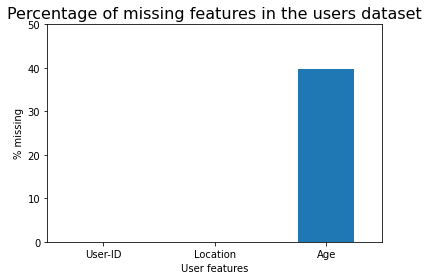

In [ ]:
#percentage of missing data from the users dataset relative to the number of users
plt.figure()
(users.isnull().sum()/len(users)*100).plot.bar()
plt.ylim((0,50))
plt.xlabel("User features")
plt.xticks(rotation=0)
plt.ylabel("% missing")
plt.title("Percentage of missing features in the users dataset", fontsize=16)

<AxesSubplot:xlabel='Age'>

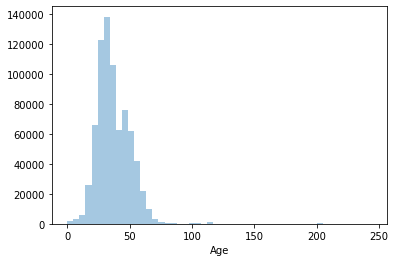

In [ ]:
sns.distplot(data['Age'].dropna(), kde=False)

In [ ]:
print('Number of outliers: ', sum(data['Age'] > 100))

Number of outliers:  2910


In [ ]:
print(data['Book-Rating'].value_counts())

0     647294
8      91804
10     71225
7      66402
9      60778
5      45355
6      31687
4       7617
3       5118
2       2375
1       1481
Name: Book-Rating, dtype: int64


<AxesSubplot:title={'center':'Book ratings distribution'}, xlabel='Book-Rating', ylabel='count'>

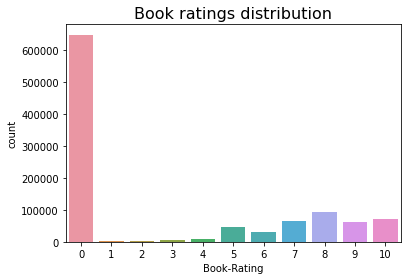

In [ ]:
plt.title('Book ratings distribution', fontsize=16)
sns.countplot(x='Book-Rating', data=data)

In [ ]:
#data['Book-Rating'] = data['Book-Rating'].replace(0, None) #this doesn't work as expected
data['Book-Rating'] = data['Book-Rating'].replace({0:np.nan})

In [ ]:
#sanity check -> this number should match the 0 count two cells above
print(f'Number of ratings with na value: {data["Book-Rating"].isna().sum()}')

Number of ratings with na value: 647294


<AxesSubplot:title={'center':'Actual book rating distribution'}, xlabel='Book-Rating', ylabel='count'>

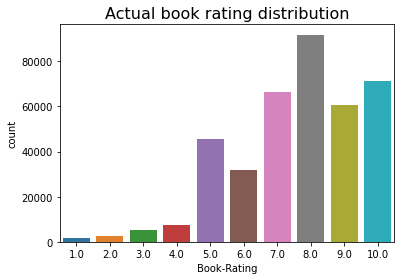

In [ ]:
plt.title('Actual book rating distribution', fontsize=16)
sns.countplot(x='Book-Rating', data=data)

In [ ]:
print('Average book rating: ', round(data['Book-Rating'].mean(), 2))

Average book rating:  7.63


In [ ]:
data.isnull().sum()

User-ID                     0
ISBN                        0
Book-Rating            647294
Location                    0
Age                    277835
Book-Title                  0
Book-Author                 1
Year-Of-Publication         0
Publisher                   2
dtype: int64

## Feature Engineering

In [ ]:
#data['Book-Rating'] = data['Book-Rating'].replace(0, None)
#0 values were already replaced with np.na a few cells above

In [ ]:
temp = data.copy()

In [ ]:
data = temp.copy()

## Age

How many null values ?

In [ ]:
data['Age'].isna().sum()

277835

What is the distribution of age ?

<AxesSubplot:xlabel='Age'>

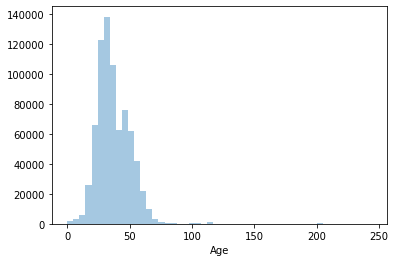

In [ ]:
sns.distplot(data['Age'].dropna(), kde=False)

How many entries over 90 yo ?

In [ ]:
(data['Age']>90).sum()

3255

Age over 90 years old is most likely a mistake.

In [ ]:
#Handle outliers -> replace with na
data['Age'] = np.where(data['Age']>90, None, data['Age'])

In [ ]:
# Impute nulls - Categorical features
data[['Book-Author', 'Publisher']] = data[['Book-Author', 'Publisher']].fillna('Unknown')

In [ ]:
# Check cat features
data[['Book-Author', 'Publisher']].isnull().sum()

Book-Author    0
Publisher      0
dtype: int64

In [ ]:
median = data["Age"].median()
std = data["Age"].std()
is_null = data["Age"].isnull().sum()
rand_age = np.random.randint(median - std, median + std, size = is_null)
age_slice = data["Age"].copy()
age_slice[pd.isnull(age_slice)] = rand_age
data["Age"] = age_slice
data["Age"] = data["Age"].astype(int)

In [ ]:
# Extract features country of the user
data['Country'] = data['Location'].apply(lambda row: str(row).split(',')[-1])

In [ ]:
data['Country'].head()

0     usa
1     usa
2     usa
3     usa
4     usa
Name: Country, dtype: object

Minimize sample size otherwise too big for execution in deepnote, n=8000

In [ ]:
data_min = data.sample(n=8000).reset_index(drop=True)

Generate a random sample of 2 users for testing purposes

In [ ]:
random_sample = data_min.sample(n = 2, random_state=42) 
random_sample

,User-ID,ISBN,Book-Rating,Location,Age,Book-Title,Book-Author,Year-Of-Publication,Publisher,Country
2215,106816,096154371X,NaN,"independence, missouri, usa",57,The art of getting well!: Rheumatoid arthritis...,Anthony Di Fabio,1988,Rheumatoid Disease Foundation,usa
2582,273714,0743207432,NaN,"yokine, western australia, australia",44,Wheelers,Jack Cohen,2001,Simon &amp; Schuster (Trade Division),australia


## 1. Content-based Recommender System

**Problem Formulation:**    
Build a recommender system that recommends based on book titles. So if our user gives us a book title, our goal is to recommend books that have similar titles.

In [ ]:
df_books = data_min[['ISBN','Book-Title','Book-Author','Year-Of-Publication']].drop_duplicates()
df_books.shape

(7081, 4)

<AxesSubplot:title={'center':'Word Count Distribution for book title'}, ylabel='Frequency'>

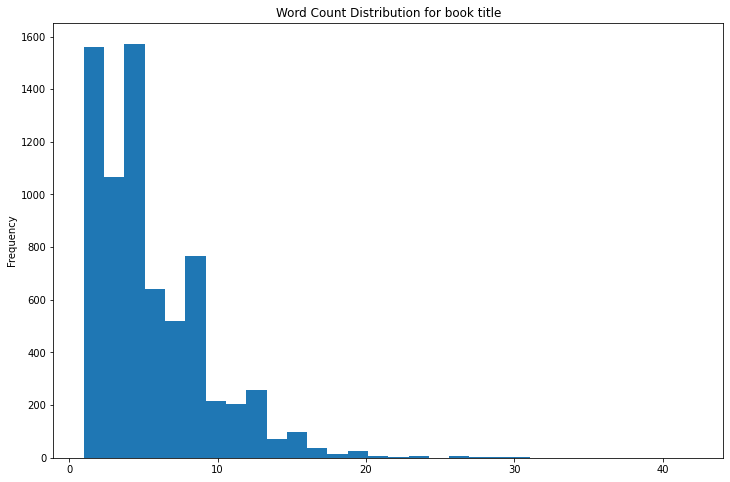

In [ ]:
# Calculate the word count for book title
df_books['word_count'] = df_books['Book-Title'].apply(lambda x: len(str(x).split()))

# Plotting the word count
df_books['word_count'].plot(
    kind='hist',
    bins = 30,
    figsize = (12,8),title='Word Count Distribution for book title')

In [ ]:
df_books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,word_count
0,0312181736,Second Coming Attractions,David Prill,1998,3
1,155874262X,Chicken Soup for the Soul (Chicken Soup for th...,Jack Canfield,1993,10
2,0141308206,Summer Reading Is Killing Me! (Time Warp Trio),Jon Scieszka,2000,8
3,088995092X,The Substance of Forgetting (Fiction),Kirstjana Gunnars,1993,5
4,0553585177,Fires of the Faithful,Naomi Kritzer,2002,4


**TF(Term Frequency)-IDF(Inverse Document Frequency) **  
- TFIDF(word) = TF(Document, Word) * IDF (Word)  
- The TF of a word is the frequency of a word (i.e. number of times it appears) in a document.    
- The IDF of a word is the measure of how significant that term is in the whole corpus; log(Nr of documents / Nr of documents containing word)
- Unigrams vs. Bigrams: Bigram is 2 consecutive words in a sentence. E.g. “The boy is playing football”. The bigrams here are: "The boy", "boy is"...

More: https://www.youtube.com/watch?v=ouEVPRMHR1U 

**Cosine Similarity:**  
Cosine similarity is a measure of similarity between two non zero vectors. One of the beautiful thing about vector representation is we can now see how closely related two sentence are based on what angles their respective vectors make.

- Cosine value ranges from -1 to 1.
- If two vectors make an angle 0, then cosine value would be 1, which in turn would mean that the sentences are closely related to each other.
- If the two vectors are orthogonal, i.e. cos 90 then it would mean that the sentences are almost unrelated. 

Source: https://www.linkedin.com/pulse/content-based-recommender-engine-under-hood-venkat-raman/

In [ ]:
# Function for recommending books based on Book title. It takes book title as an input.
def recommend(title):
    
    # Convert the index into series
    indices = pd.Series(data_min.index, index = data_min['Book-Title'])
    
    #Natural Language Processing: converting the book title (str) into vectors bigrams 
        #- ngram_range = unigram/bigram/trigram ...
        #- min_df = When building the vocabulary ignore terms that have a document frequency strictly lower than the given threshold
    tf = TfidfVectorizer(analyzer='word', ngram_range=(2, 2), min_df = 1)
    tfidf_matrix = tf.fit_transform(data_min['Book-Title'])

    #print(tfidf_matrix)
    #print(tfidf_matrix.shape)
    
    # Calculating the similarity measures based on Cosine Similarity
    sg = cosine_similarity(tfidf_matrix,tfidf_matrix)

    # Get the index corresponding to original_title       
    idx = indices[title]
    # Get the pairwsie similarity scores 
    sig = list(enumerate(sg[idx]))

    # Sort the books
    sig = sorted(sig, key=lambda x: x[1], reverse=True)
    # Scores of the 3 most similar books 
    sig = sig[1:4]

    # Book indicies
    book_indices = [i[0] for i in sig]

     
    # Top 5 book recommendation
    rec = data_min[['Book-Title', 'Book-Author', 'Year-Of-Publication']].iloc[book_indices]
    print("After reading '" + title + "' make sue to check out those books:")
    print("--------------------") 
    counter = 1
    for index,row in rec.iterrows():
        print(f"Recommendation {counter}:")
        print(f"{rec['Book-Title'][index]} by {rec['Book-Author'][index]} with {round(sig[counter - 1][1], 3)} similarity score") 
        print("--------------------") 
        counter = counter + 1


In [ ]:
# test recommendation based on random book title 
#recommend(df_books['Book-Title'].iloc[4])

In [ ]:
'''for index,row in random_sample.iterrows():
    #selected_user = data_min[data_min['Book-Title'] == random_sample['Book-Title'][index]].sort_values(by='Book-Rating', ascending=False).head(1)["User-ID"]
    #print(f"For user {selected_user} we recommend the following.")
    print("----------------------------------------") 
    recommend(random_sample['Book-Title'][index])
    '''


'for index,row in random_sample.iterrows():\n    #selected_user = data_min[data_min[\'Book-Title\'] == random_sample[\'Book-Title\'][index]].sort_values(by=\'Book-Rating\', ascending=False).head(1)["User-ID"]\n    #print(f"For user {selected_user} we recommend the following.")\n    print("----------------------------------------") \n    recommend(random_sample[\'Book-Title\'][index])\n    '

## 2. Collaborative Filtering Memory-Based Recommender System

### Problem Formulation:
Build a recommender system that recommends books based on the users similarity in books rating.

In [ ]:
df_users = data[['User-ID', 'Age', 'Country','ISBN','Book-Rating','Book-Title']]
df_users.shape

(1031136, 6)

In [ ]:
df_users_min = df_users.sample(n=8000).reset_index(drop=True)

array([[<AxesSubplot:title={'center':'Book-Rating'}>,
        <AxesSubplot:title={'center':'User-ID'}>]], dtype=object)

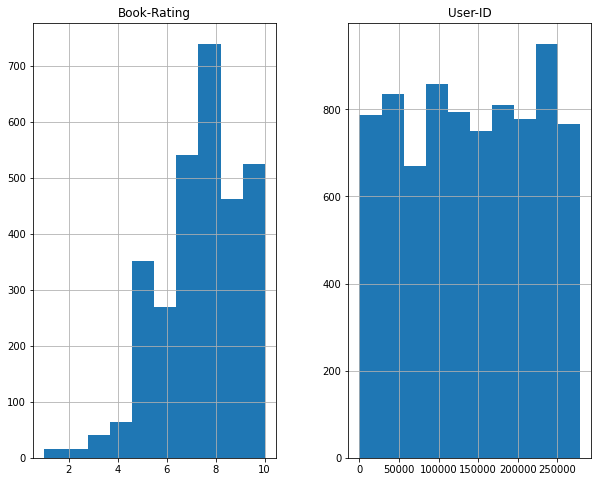

In [ ]:
df_users_min.hist(figsize=(10,8))

In [ ]:
df_users_min.head()

,User-ID,Age,Country,ISBN,Book-Rating,Book-Title
0,23768,45,usa,0688156983,10.0,Blues: For All the Changes : New Poems
1,178522,46,,0671673661,8.0,I'LL BE SEEING YOU
2,213255,32,united kingdom,042510107X,NaN,Red Storm Rising
3,187256,40,usa,0553574574,NaN,Beach Music
4,11503,37,usa,0316690619,6.0,Cradle and All


### Creating the matrix

In [ ]:
matrix=df_users_min.pivot(index="User-ID",columns="ISBN",values="Book-Rating")

In [ ]:
matrix.fillna(0,inplace=True)

#### Cosine similiarity between the users


In [ ]:
cos_sim = cosine_similarity(matrix)
np.fill_diagonal(cos_sim,0)        # zero here means that both ids are same,it should be 1 here but i am using 0 so as to ease further coding process
rec_cos=pd.DataFrame(cos_sim,index=matrix.index)
rec_cos.columns=matrix.index
rec_cos.head()

User-ID,17,243,254,440,507,643,728,741,882,1113,...,32041,32154,32195,32250,32252,32440,32483,32524,32547,32569
User-ID,,,,,,,,,,,,,,,,,,,,,
17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
243,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
254,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
440,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
507,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


##### Validating our result using user id

In [ ]:
df_users_min[df_users_min["User-ID"]==16795.0][["Book-Title","Book-Rating"]].head()

,Book-Title,Book-Rating
206,The Fennel Family Papers: A Novel,NaN
283,Circle of Friends,9.0
595,The Cider House Rules,5.0
714,Teklab,8.0
1348,Team Player (Scrappers),NaN


### Building a function to show top 3 users that are similiar to input random user


In [ ]:
def sim(userid,n):          # userid is the id for which recommendations has to be made, n represents total no. of similiar users wanted 
    print(np.array(rec_cos[userid].sort_values(ascending=False).head(n).index))

In [ ]:
print(np.array(rec_cos[150968.0].sort_values(ascending=False).head(3).index))

[278610  94886  94781]


In [ ]:
data[data["User-ID"]==200226.0][["Age","Location"]].head()

,Age,Location
140,39,"burlington, ontario, canada"
708,39,"burlington, ontario, canada"
874,39,"burlington, ontario, canada"
2770,39,"burlington, ontario, canada"
3201,39,"burlington, ontario, canada"


In [ ]:
data[data["User-ID"]==20119.0][["Age","Location"]].head()

,Age,Location
1007,51,"manchester, new hampshire,"
9136,51,"manchester, new hampshire,"
13414,51,"manchester, new hampshire,"
19049,51,"manchester, new hampshire,"
26978,51,"manchester, new hampshire,"


In [ ]:
data[data["User-ID"]==125039.0][["Age","Location"]].head()

,Age,Location
6267,27,"lafayette, indiana, usa"
7140,27,"lafayette, indiana, usa"
9329,27,"lafayette, indiana, usa"
14961,27,"lafayette, indiana, usa"
15779,27,"lafayette, indiana, usa"


In [ ]:
print(np.array(rec_cos[26544.0].sort_values(ascending=False).head(3).index))

[278610  94886  94781]


In [ ]:
data[data["User-ID"]==123054.0][["Age","Location"]].head()

,Age,Location
165111,29,"houston, texas, usa"
437259,42,"houston, texas, usa"
487745,46,"houston, texas, usa"
898697,23,"houston, texas, usa"
898699,29,"houston, texas, usa"


In [ ]:
data[data["User-ID"]==54885.0][["Age","Location"]].head()

,Age,Location
42868,30,"astoria, new york, usa"
190720,30,"astoria, new york, usa"


In [ ]:
data[data["User-ID"]==168144.0][["Age","Location"]].head()

,Age,Location
3625,46,"oceanside, california, usa"
4301,46,"oceanside, california, usa"
14370,46,"oceanside, california, usa"
17398,46,"oceanside, california, usa"
18929,46,"oceanside, california, usa"


In [ ]:
def book_recommender():              # userid is the id for which recommendations has to be made, n represents total no. of similiar users wanted 
    print()
    print()
    userid = int(input("Enter the user id to whom you want to recommend : "))
    print()
    print()
    n= int(input("Enter how many books you want to recommend : "))
    print()
    print()
    arr=np.array(rec_cos[userid].sort_values(ascending=False).head(5).index)
    recom_arr=[]

    for i in arr:
        recom_arr.append(data[data["User-ID"]==i][["Book-Title","Book-Rating"]].sort_values(by="Book-Rating",ascending=False))
    
    return(pd.Series(recom_arr[0].append([recom_arr[1],recom_arr[2],recom_arr[3],recom_arr[4]]).groupby("Book-Title")["Book-Rating"].mean().sort_values(ascending=False).index).head(n))

### Testing 

In [ ]:
#book_recommender()

## 3. Collaborative Filtering Model-Based Recommender System

In [ ]:
#data_mih = data_min.copy()
data_mih = data.copy()

In [ ]:
data_mih.shape

(1031136, 10)

**Missing values**

In [ ]:
data_mih.isna().sum()

User-ID                     0
ISBN                        0
Book-Rating            647294
Location                    0
Age                         0
Book-Title                  0
Book-Author                 0
Year-Of-Publication         0
Publisher                   0
Country                     0
dtype: int64

It doesn't make sense to keep in our reviews dataset entries where the review is missing.  
We either add entries for all combinations of (user, book) missing reviews or we remove all entries there review for (user, book) is 0.

In [ ]:
print('Before: ', data_mih.shape)
data_mih = data_mih.dropna()
print('After dropping null reviews: ', data_mih.shape)

Before:  (1031136, 10)
After dropping null reviews:  (383842, 10)


In [ ]:
print(f"Number of users in our train set: {data_mih['User-ID'].nunique()}")
print(f"Number of books in our train set: {data_mih['ISBN'].nunique()}")
print(f"Train set shape: {data_mih.shape}")

Number of users in our train set: 68091
Number of books in our train set: 149836
Train set shape: (383842, 10)


Frequency of number of reviews / user. Most users gave 0-3 reviews
1     39223
2      8674
3      4575
4      2832
5      2003
6      1452
7      1116
8       863
9       764
10      608
Name: Book-Rating, dtype: int64


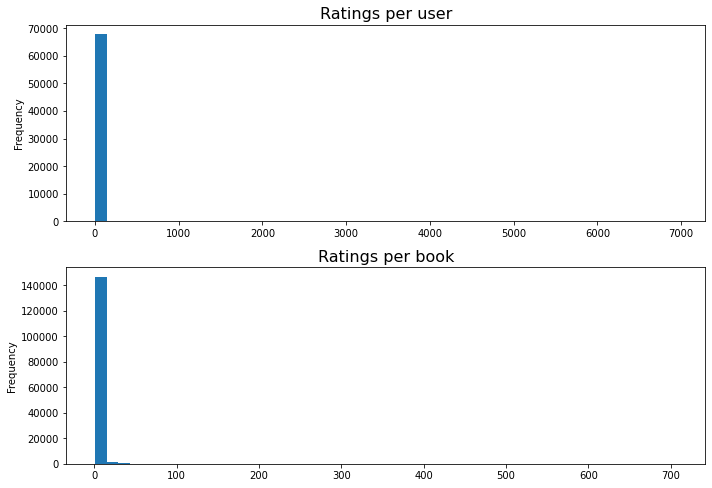

In [ ]:
#data_mih.groupby('User-ID')['Book-Rating'].count().reset_index().sort_values('Book-Rating', ascending=False).hist()
print('Frequency of number of reviews / user. Most users gave 0-3 reviews')
print(data_mih.groupby('User-ID')['Book-Rating'].count().value_counts()[:10])

fig = plt.figure(figsize=(10,10))
'''
plt.subplot(3, 1, 1)
data_mih.groupby('User-ID')['Book-Rating'].count().value_counts().plot(kind='bar')
plt.title('Top frequencies of ratings per user', fontsize=16)
'''
plt.subplot(3, 1, 2)
data_mih.groupby('User-ID')['Book-Rating'].count().plot(kind='hist', bins=50)
plt.title('Ratings per user', fontsize=16)

plt.subplot(3, 1, 3)
data_mih.groupby('ISBN')['Book-Rating'].count().plot(kind='hist', bins=50)
plt.title('Ratings per book', fontsize=16)
plt.tight_layout()
plt.show()

Most prolific users

In [ ]:
#df.groupby('userID')['bookRating'].count().reset_index().sort_values('bookRating', ascending=False)[:10]
print('Most prolific users: Descending order of highest number of reviews given by a user')
data_mih.groupby('User-ID')['Book-Rating'].count().reset_index().sort_values('Book-Rating', ascending=False)[:10]

Most prolific users: Descending order of highest number of reviews given by a user


,User-ID,Book-Rating
2719,11676,6943
24101,98391,5691
46279,189835,1899
37648,153662,1845
5615,23902,1180
57320,235105,1020
18757,76499,1012
41781,171118,962
3902,16795,959
60772,248718,941


Most of the users gave less than 5 ratings.  
There are few users who gave many ratings.  
The most productive user gave 7000 ratings.

**Most popular books**

In [ ]:
#df.groupby('userID')['bookRating'].count().reset_index().sort_values('bookRating', ascending=False)[:10]
print('Most popular books: Descending order of highest number of reviews received by a book')
data_mih.groupby('ISBN')['Book-Rating'].count().reset_index().sort_values('Book-Rating', ascending=False)[:10]

Most popular books: Descending order of highest number of reviews received by a book


,ISBN,Book-Rating
21945,0316666343,707
117745,0971880107,581
38819,0385504209,487
18058,0312195516,383
4131,0060928336,320
68898,059035342X,313
12325,0142001740,307
51799,0446672211,295
47986,044023722X,281
57625,0452282152,278


**Filter out unpopular books and rarely rating users**

We want to reduce dimensionality of our dataset (too large & sparse).  

We will filter out rarely rated books and rarely rating users.

In [ ]:
min_book_ratings = 50
filter_books = data_mih['ISBN'].value_counts() > min_book_ratings
filter_books = filter_books[filter_books].index.tolist()

min_user_ratings = 50
filter_users = data_mih['User-ID'].value_counts() > min_user_ratings
filter_users = filter_users[filter_users].index.tolist()

data_mih_new = data_mih[(data_mih['ISBN'].isin(filter_books)) & (data_mih['User-ID'].isin(filter_users))]
print('The original data frame shape:\t{}'.format(data_mih.shape))
print('The new data frame shape:\t{}'.format(data_mih_new.shape))

The original data frame shape:	(383842, 10)
The new data frame shape:	(13137, 10)


In [ ]:
print(f"Number of users in our restricted train set: {data_mih_new['User-ID'].nunique()}")
print(f"Number of books in our restricted train set: {data_mih_new['ISBN'].nunique()}")
print(f"Restricted train set shape: {data_mih_new.shape}")

Number of users in our restricted train set: 1079
Number of books in our restricted train set: 507
Restricted train set shape: (13137, 10)


### Surprise package - how to use the library

"A Python scikit for recommender systems"

Provides multiple prediction algorithms: 
- baseline algorithms
- neighborhood methods
- matrix factorization-based ( SVD, PMF, SVD++, NMF)
- and more. 

Also, various similarity measures (cosine, MSD, pearson…) are built-in.


In [ ]:
from collections import defaultdict
from surprise import SVD
from surprise import Dataset


def get_top_n(predictions, n=10):
    """Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    """

    # First map the predictions to each user.
    top_n = defaultdict(list)
    all_pred = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        all_pred[uid].append((iid, est))
    #print(all_pred)
    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in all_pred.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n


def play_surprise():
    # First train an SVD algorithm on the movielens dataset.
    data_surprise = Dataset.load_builtin('ml-100k')
    trainset = data_surprise.build_full_trainset()
    algo = SVD()
    algo.fit(trainset)

    # Than predict ratings for all pairs (u, i) that are NOT in the training set.
    testset = trainset.build_anti_testset()
    predictions = algo.test(testset)

    top_n = get_top_n(predictions, n=10)

    # Print the first 10 recommended items for each user (in decreasing order of their estimated rating)
    for uid, user_ratings in top_n.items():
        print(uid, [iid for (iid, _) in user_ratings])
        #print(uid, [est for (_, est) in user_ratings])

#play_surprise()

### Preparing dataset for Surprise

In [ ]:
data_mih = data_mih_new.copy()

In [ ]:
data_mih.isna().sum()

User-ID                0
ISBN                   0
Book-Rating            0
Location               0
Age                    0
Book-Title             0
Book-Author            0
Year-Of-Publication    0
Publisher              0
Country                0
dtype: int64

In [ ]:
from surprise import Reader, Dataset, SVD, SVDpp, SlopeOne, NMF, NormalPredictor, KNNBaseline
from surprise import KNNBasic, KNNWithMeans, KNNWithZScore, BaselineOnly, CoClustering

'''
 classmethod load_from_df(df, reader)

    Load a dataset from a pandas dataframe.

    Use this if you want to use a custom dataset that is stored in a pandas dataframe. See the User Guide for an example.
    Parameters:	

        df (Dataframe) – The dataframe containing the ratings. It must have three columns, corresponding to the user (raw) ids, the item (raw) ids, and the ratings, in this order.
        reader (Reader) – A reader to read the file. Only the rating_scale field needs to be specified.

'''
reader = Reader(rating_scale=(0, 10))
data_surprise = Dataset.load_from_df(data_mih[['User-ID', 'ISBN', 'Book-Rating']], reader)

trainset = data_surprise.build_full_trainset() 

In [ ]:
print(f'Surprise trainset items: {trainset.n_items}')
print(f'Surprise trainset users: {trainset.n_users}')
print(f'Surprise trainset ratings: {trainset.n_ratings}')

Surprise trainset items: 507
Surprise trainset users: 1079
Surprise trainset ratings: 13137


### Model training

Read about SVD model parameters here: https://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.SVD

In [ ]:
svd_model = SVD(n_epochs = 20, n_factors = 50)
svd_model.fit(trainset)

### Model prediction

In [ ]:
random_sample

,User-ID,ISBN,Book-Rating,Location,Age,Book-Title,Book-Author,Year-Of-Publication,Publisher,Country
2215,81977,0385472625,NaN,"minneapolis, minnesota, usa",34,To Be Real: Telling the Truth and Changing the...,Rebecca Walker,1995,Anchor Books/Doubleday,usa
2582,26544,0515107662,NaN,"woodbridge, virginia, usa",37,The Sherbrooke Bride (Bride Trilogy (Paperback)),Catherine Coulter,1996,Jove Books,usa


How to use the predict method in Surprise package: https://surprise.readthedocs.io/en/stable/getting_started.html

In [ ]:
for i in range(0,10):
#   pred = svd_model.predict(data_mih['User-ID'][i], data_mih['ISBN'][i], r_ui=data_mih['Book-Rating'][i], verbose=True)
    pred = svd_model.predict(data_mih['User-ID'].iloc[i], 
        data_mih['ISBN'].iloc[i], 
        r_ui=data_mih['Book-Rating'].iloc[i], verbose=True)

user: 7158       item: 0446520802 r_ui = 10.00   est = 8.26   {'was_impossible': False}
user: 8253       item: 0446520802 r_ui = 10.00   est = 9.59   {'was_impossible': False}
user: 11676      item: 0446520802 r_ui = 10.00   est = 9.56   {'was_impossible': False}
user: 23768      item: 0446520802 r_ui = 6.00   est = 7.39   {'was_impossible': False}
user: 27617      item: 0446520802 r_ui = 9.00   est = 8.62   {'was_impossible': False}
user: 30711      item: 0446520802 r_ui = 6.00   est = 7.69   {'was_impossible': False}
user: 85993      item: 0446520802 r_ui = 10.00   est = 9.07   {'was_impossible': False}
user: 141444     item: 0446520802 r_ui = 7.00   est = 6.82   {'was_impossible': False}
user: 153718     item: 0446520802 r_ui = 7.00   est = 7.96   {'was_impossible': False}
user: 154992     item: 0446520802 r_ui = 8.00   est = 7.96   {'was_impossible': False}


In [ ]:
#pred = svd_model.predict(random_sample['User-ID'][0], random_sample['ISBN'][0], r_ui=random_sample['Book-Rating'][0], verbose=True)
pred = svd_model.predict(10447, '0395633206', r_ui=4, verbose=True)

user: 10447      item: 0395633206 r_ui = 4.00   est = 7.36   {'was_impossible': False}


In [ ]:
pred = svd_model.predict(185233, '0590494457', r_ui=5, verbose=True)

user: 185233     item: 0590494457 r_ui = 5.00   est = 6.89   {'was_impossible': False}


## Models comparison

In [ ]:
#from sklearn.model_selection import cross_validate
from surprise.model_selection import cross_validate

reader = Reader(rating_scale=(0, 10))
data_surprise = Dataset.load_from_df(data_mih[['User-ID', 'ISBN', 'Book-Rating']], reader)

benchmark = []

# Iterate over all algorithms
for algorithm in [SVD(), SVDpp(), SlopeOne(), NMF(), NormalPredictor(), KNNBaseline(), KNNBasic(), KNNWithMeans(), KNNWithZScore(), BaselineOnly(), CoClustering()]:
    print('Currently running ... ', algorithm)

    # Perform cross validation
    results = cross_validate(algorithm, data_surprise, measures=['RMSE'], cv=3, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    print('Results: ', tmp)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    
pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse') 

Currently running ...  <surprise.prediction_algorithms.matrix_factorization.SVD object at 0x7fd27011b8d0>
Results:  test_rmse    1.541106
fit_time     0.458458
test_time    0.033519
dtype: float64
Currently running ...  <surprise.prediction_algorithms.matrix_factorization.SVDpp object at 0x7fd2947cc710>
Results:  test_rmse    1.554333
fit_time     2.752924
test_time    0.152736
dtype: float64
Currently running ...  <surprise.prediction_algorithms.slope_one.SlopeOne object at 0x7fd2701aae10>
Results:  test_rmse    1.821719
fit_time     0.022869
test_time    0.085147
dtype: float64
Currently running ...  <surprise.prediction_algorithms.matrix_factorization.NMF object at 0x7fd2701aacd0>
Results:  test_rmse    2.589037
fit_time     0.553763
test_time    0.024277
dtype: float64
Currently running ...  <surprise.prediction_algorithms.random_pred.NormalPredictor object at 0x7fd270124850>
Results:  test_rmse    2.324858
fit_time     0.012608
test_time    0.025826
dtype: float64
Currently runnin

,test_rmse,fit_time,test_time
Algorithm,,,
SVD,1.541106,0.458458,0.033519
SVDpp,1.554333,2.752924,0.152736
BaselineOnly,1.557284,0.014358,0.019062
CoClustering,1.671764,0.222740,0.021643
KNNBaseline,1.685133,0.045200,0.181265
KNNWithZScore,1.696461,0.094614,0.170978
KNNWithMeans,1.700369,0.047314,0.144173
KNNBasic,1.796285,0.034052,0.134574
SlopeOne,1.821719,0.022869,0.085147


## Comparison with content-based and with memory-based collaborative filtering

In [ ]:
print(data_min.shape)
data_min.isna().sum()

(8000, 10)


User-ID                   0
ISBN                      0
Book-Rating            5010
Location                  0
Age                       0
Book-Title                0
Book-Author               0
Year-Of-Publication       0
Publisher                 0
Country                   0
dtype: int64

In [ ]:
data_mih_min = data_min.dropna()
print(data_mih_min.shape)

(3025, 10)


### Train SVD model

In [ ]:
from surprise import Reader, Dataset, SVD

reader = Reader(rating_scale=(1, 10))
data_surprise = Dataset.load_from_df(data_mih_min[['User-ID', 'ISBN', 'Book-Rating']], reader)

trainset = data_surprise.build_full_trainset() 

svd_model = SVD(n_epochs = 20, n_factors = 50)
svd_model.fit(trainset)

In [ ]:
random_sample

,User-ID,ISBN,Book-Rating,Location,Age,Book-Title,Book-Author,Year-Of-Publication,Publisher,Country
2215,81977,0385472625,NaN,"minneapolis, minnesota, usa",34,To Be Real: Telling the Truth and Changing the...,Rebecca Walker,1995,Anchor Books/Doubleday,usa
2582,26544,0515107662,NaN,"woodbridge, virginia, usa",37,The Sherbrooke Bride (Bride Trilogy (Paperback)),Catherine Coulter,1996,Jove Books,usa


In [ ]:
for i in range(0,random_sample.shape[0]):
#   pred = svd_model.predict(data_mih['User-ID'][i], data_mih['ISBN'][i], r_ui=data_mih['Book-Rating'][i], verbose=True)
    pred = svd_model.predict(random_sample['User-ID'].iloc[i], 
        random_sample['ISBN'].iloc[i], 
        r_ui=random_sample['Book-Rating'].iloc[i], verbose=True)

user: 81977      item: 0385472625 r_ui = nan   est = 7.59   {'was_impossible': False}
user: 26544      item: 0515107662 r_ui = nan   est = 7.37   {'was_impossible': False}


In [ ]:
random_sample[['User-ID', 'ISBN', 'Book-Rating']]

,User-ID,ISBN,Book-Rating
2215,81977,0385472625,NaN
2582,26544,0515107662,NaN


In [ ]:
uid = 184339
data_mih_min[data_mih_min['User-ID']==uid]

,User-ID,ISBN,Book-Rating,Location,Age,Book-Title,Book-Author,Year-Of-Publication,Publisher,Country


In [ ]:
def get_top_n(predictions, n=10):
    """Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    """

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [ ]:
from surprise import Reader, Dataset, SVD

# Then predict ratings for all pairs (u, i) that are NOT in the training set.
testset = trainset.build_anti_testset()
predictions = svd_model.test(testset)

top_n = get_top_n(predictions, n=10)

# Print the recommended items for each user
for uid, user_ratings in top_n.items():
    print(uid, [iid for (iid, _) in user_ratings])

KernelInterrupted: Execution interrupted by the Jupyter kernel.

<AxesSubplot:>

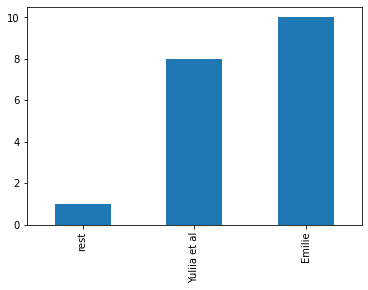

In [ ]:
import pandas as pd
levels = pd.Series([1, 8, 10], index = ['rest', 'Yuliia et al', 'Emilie'])
levels.plot(kind='bar')